In [192]:
import numpy as np
from dataclasses import dataclass, field
from collections import deque
import matplotlib.pyplot as plt
import pandas as pd
import os
import pandas as pd
import numpy as np
from ahrs.filters import madgwick
from ahrs.common.orientation import q2euler
from scipy import signal


In [193]:
# Constants
FS = 104                 # Sampling frequency [Hz]
DT = 1.0 / FS            # Sample period [s]
RAD_TO_DEG = 180.0 / np.pi
DEG_TO_RAD = np.pi / 180.0
DPS_IS_MILI = False

# Detection thresholds
ALTITUDE_THRESHOLD = 1.0  # degrees
AZIMUTH_THRESHOLD = 5.0   # degrees

# Csv path(s)
# csv_path = "raw_data/motion_data_eventful.csv"
csv_path = "raw_data/motion_data_104.csv"

TAKE_OWN_TIMESTAMP = True

# Raw Data Analysis

In [194]:
def load_and_validate_imu_data(csv_path, expected_fs=104):
    if not os.path.exists(csv_path):
        raise FileNotFoundError(f"CSV file not found: {csv_path}")

    df = pd.read_csv(csv_path)
    
    # Extract sensor data
    acc_data_mg = df[['accel_x_mg', 'accel_y_mg', 'accel_z_mg']].values
    gyro_data_raw = df[['gyro_x_dps', 'gyro_y_dps', 'gyro_z_dps']].values
    
    gyro_mean_magnitude = np.mean(np.sqrt(np.sum(gyro_data_raw**2, axis=1)))
    
    if gyro_mean_magnitude > 100:
        print("Detected: Gyroscope data is in millidegrees per second (mdps)")
        gyro_units = "mdps"
        gyro_data_dps = gyro_data_raw / 1000.0
        df['gyro_x_mdps'] = gyro_data_raw[:, 0]
        df['gyro_y_mdps'] = gyro_data_raw[:, 1] 
        df['gyro_z_mdps'] = gyro_data_raw[:, 2]
        df['gyro_x_dps'] = gyro_data_dps[:, 0]
        df['gyro_y_dps'] = gyro_data_dps[:, 1]
        df['gyro_z_dps'] = gyro_data_dps[:, 2]
    else:
        print("Detected: Gyroscope data is in degrees per second (dps)")
        gyro_units = "dps"
        gyro_data_dps = gyro_data_raw
        df['gyro_x_mdps'] = gyro_data_raw[:, 0] * 1000
        df['gyro_y_mdps'] = gyro_data_raw[:, 1] * 1000
        df['gyro_z_mdps'] = gyro_data_raw[:, 2] * 1000
    
    # Time analysis
    if TAKE_OWN_TIMESTAMP:
        df['timestamp_us'][0] = 0
        df['relative_time_ms'][0] = 0
        for i in range(len(df['timestamp_us'])):
            df['timestamp_us'][i+1] = df['timestamp_us'][i] + (1/104 * 1000000)
            df['relative_time_ms'][i+1] = df['relative_time_ms'][i] + (1/104 * 1000000)

    timestamps = df['timestamp_us'].values / 1000000.0
    duration = timestamps[-1] - timestamps[0]
    actual_fs = len(timestamps) / duration
    
    # Calculate actual sampling intervals
    time_diffs = np.diff(timestamps)
    median_dt = np.median(time_diffs)
    actual_fs_from_median = 1.0 / median_dt
    
    print(f"\nDATA SUMMARY:")
    print(f"   - Duration: {duration:.1f} seconds")
    print(f"   - Sample count: {len(timestamps)}")
    print(f"   - Expected rate: {expected_fs} Hz")
    print(f"   - Actual rate (average): {actual_fs:.1f} Hz")
    print(f"   - Actual rate (from median Δt): {actual_fs_from_median:.1f} Hz")
    print(f"   - Rate accuracy: {100 * actual_fs / expected_fs:.1f}%")
    print(f"   - Gyroscope units: {gyro_units}")
    
    # Data quality warnings
    if abs(actual_fs - expected_fs) > 5:
        print("  WARNING: Significant sampling rate mismatch!")
        print(f"   Using actual rate of {actual_fs:.1f} Hz for analysis")
        
    if np.std(time_diffs) > median_dt * 0.1:
        print("️  WARNING: Irregular sampling detected!")
        print(f"   Time interval std: {np.std(time_diffs)*1000:.2f} ms")
    
    return df, actual_fs, gyro_units, {
        'duration': duration,
        'actual_fs': actual_fs,
        'median_dt': median_dt,
        'time_irregularity': np.std(time_diffs) / median_dt
    }

df, afs, gyro_units, extra = load_and_validate_imu_data(csv_path, FS)

Detected: Gyroscope data is in millidegrees per second (mdps)

DATA SUMMARY:
   - Duration: 158.4 seconds
   - Sample count: 16479
   - Expected rate: 104 Hz
   - Actual rate (average): 104.0 Hz
   - Actual rate (from median Δt): 104.0 Hz
   - Rate accuracy: 100.0%
   - Gyroscope units: mdps


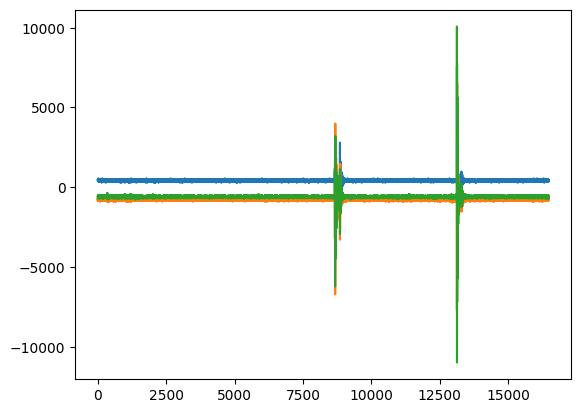

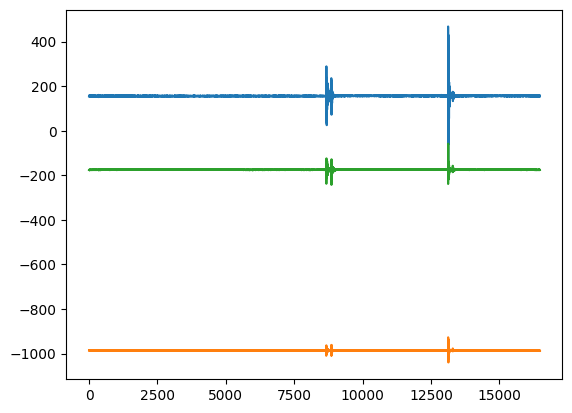

In [195]:
gyro_mdps = df[['gyro_x_mdps', 'gyro_y_mdps', 'gyro_z_mdps']]
accel_mg = df[['accel_x_mg', 'accel_y_mg', 'accel_z_mg']]
plt.plot(gyro_mdps)
plt.show()
plt.plot(accel_mg)
plt.show()

In [196]:
df.head()

,timestamp_us,relative_time_ms,accel_x_mg,accel_y_mg,accel_z_mg,gyro_x_dps,gyro_y_dps,gyro_z_dps,accel_magnitude,gyro_magnitude,gyro_x_mdps,gyro_y_mdps,gyro_z_mdps
0,0.000000,0.000000,155.0,-986.0,-176.0,0.42,-0.77,-0.63,1013.507277,1079.907403,420.0,-770.0,-630.0
1,9615.384615,9615.384615,158.0,-986.0,-175.0,0.42,-0.70,-0.63,1013.797317,1031.164390,420.0,-700.0,-630.0
2,19230.769231,19230.769231,157.0,-986.0,-175.0,0.49,-0.84,-0.56,1013.641949,1122.185368,490.0,-840.0,-560.0
3,28846.153846,28846.153846,158.0,-987.0,-175.0,0.42,-0.84,-0.49,1014.769925,1059.292217,420.0,-840.0,-490.0
4,38461.538462,38461.538462,155.0,-986.0,-175.0,0.42,-0.77,-0.49,1013.334101,1004.689007,420.0,-770.0,-490.0


In [197]:
def analyze_imu_statistics(df, gyro_units="dps"):
    # Accelerometer analysis
    acc_cols = ['accel_x_mg', 'accel_y_mg', 'accel_z_mg']
    acc_axes = ['X (West)', 'Y (Down)', 'Z (South)']
    
    print(f"\nACCELEROMETER STATISTICS (mg):")
    print("-" * 60)
    print(f"{'Axis':12} | {'Mean':>8} | {'Std':>8} | {'Min':>8} | {'Max':>8} | {'RMS':>8}")
    print("-" * 60)
    
    for i, (col, axis) in enumerate(zip(acc_cols, acc_axes)):
        data = df[col]
        rms = np.sqrt(np.mean(data**2))
        print(f"{axis:12} | {data.mean():8.1f} | {data.std():8.1f} | {data.min():8.1f} | {data.max():8.1f} | {rms:8.1f}")
    
    # Gyroscope analysis
    if gyro_units == "mdps":
        gyro_cols = ['gyro_x_mdps', 'gyro_y_mdps', 'gyro_z_mdps']
        gyro_label = "GYROSCOPE STATISTICS (mdps)"
    else:
        gyro_cols = ['gyro_x_dps', 'gyro_y_dps', 'gyro_z_dps']
        gyro_label = "GYROSCOPE STATISTICS (dps)"
    
    print(f"\n  {gyro_label}:")
    print("-" * 60)
    print(f"{'Axis':12} | {'Mean':>8} | {'Std':>8} | {'Min':>8} | {'Max':>8} | {'RMS':>8}")
    print("-" * 60)
    
    for i, (col, axis) in enumerate(zip(gyro_cols, acc_axes)):
        data = df[col]
        rms = np.sqrt(np.mean(data**2))
        print(f"{axis:12} | {data.mean():8.1f} | {data.std():8.1f} | {data.min():8.1f} | {data.max():8.1f} | {rms:8.1f}")
    
    # Gravity analysis
    gravity_magnitude = np.sqrt(df['accel_x_mg']**2 + df['accel_y_mg']**2 + df['accel_z_mg']**2)
    gravity_error = np.abs(gravity_magnitude - 1000.0)
    
    print(f"\n GRAVITY ANALYSIS:")
    print("-" * 40)
    print(f"   - Mean magnitude: {gravity_magnitude.mean():.1f} mg")
    print(f"   - Std deviation: {gravity_magnitude.std():.1f} mg")
    print(f"   - Mean error from 1g: {gravity_error.mean():.1f} mg")
    print(f"   - Max error from 1g: {gravity_error.max():.1f} mg")
    
    if gravity_error.mean() > 20:
        print("️  WARNING: Accelerometer may need calibration!")
    
    # Motion activity analysis
    acc_total_variation = np.sum([np.var(df[col]) for col in acc_cols])
    gyro_total_variation = np.sum([np.var(df[col]) for col in gyro_cols])
    
    print(f"\n ACTIVITY ANALYSIS:")
    print("-" * 40)
    print(f"   - Accelerometer total variance: {acc_total_variation:.0f}")
    print(f"   - Gyroscope total variance: {gyro_total_variation:.0f}")
    
    if gyro_total_variation > 1e8:  # Adjust threshold as needed
        print("High gyroscope activity detected - expect significant motion events")
    elif gyro_total_variation < 1e4:
        print("Low gyroscope activity - mostly static data")
    else:
        print("Moderate gyroscope activity detected")
    
    return {
        'gravity_magnitude': gravity_magnitude,
        'gravity_error': gravity_error,
        'acc_total_variation': acc_total_variation,
        'gyro_total_variation': gyro_total_variation
    }

# Tools

In [198]:
def wds_to_enu(acc_wds_data: np.ndarray, gyro_wds_data: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
    acc_enu_data = np.zeros_like(acc_wds_data)
    gyro_enu_data = np.zeros_like(gyro_wds_data)
    
    acc_enu_data[:, 0] = -acc_wds_data[:, 0]  # East = -West
    acc_enu_data[:, 1] = -acc_wds_data[:, 2]  # North = -South
    acc_enu_data[:, 2] = -acc_wds_data[:, 1]  # Up = -Down
    
    gyro_enu_data[:, 0] = -gyro_wds_data[:, 0]  # East = -West
    gyro_enu_data[:, 1] = -gyro_wds_data[:, 2]  # North = -South
    gyro_enu_data[:, 2] = -gyro_wds_data[:, 1]  # Up = -Down
    
    return acc_enu_data, gyro_enu_data

In [199]:
def calculate_accel_angles_wds(df, noise_threshold=50):
    # Convert mg to g
    ax = df['accel_x_mg'].values / 1000.0
    ay = df['accel_y_mg'].values / 1000.0  
    az = df['accel_z_mg'].values / 1000.0
    
    # Calculate magnitude for validation
    magnitude = np.sqrt(ax**2 + ay**2 + az**2)

    print("MEAN MAGNITUDE ACCEL:", np.mean(magnitude))
    
    # Identify low-acceleration periods (might be unreliable for angle calculation)
    low_acc_mask = magnitude < 0.5  # Less than 0.5g
    high_acc_mask = magnitude > 1.5  # More than 1.5g (high acceleration)
    
    roll = np.arctan2(-az, -ay) * 180.0 / np.pi
    pitch = np.arctan2(ax, np.sqrt(ay**2 + az**2)) * 180.0 / np.pi
    yaw = np.arctan2(ax, -ay) * 180.0 / np.pi
    
    # Mark unreliable angle estimates
    reliable_mask = ~(low_acc_mask | high_acc_mask)
    
    print(f"ANGLE CALCULATION QUALITY:")
    print(f"   - Reliable samples: {np.sum(reliable_mask)} / {len(reliable_mask)} ({100*np.sum(reliable_mask)/len(reliable_mask):.1f}%)")
    print(f"   - Low acceleration samples: {np.sum(low_acc_mask)} ({100*np.sum(low_acc_mask)/len(low_acc_mask):.1f}%)")
    print(f"   - High acceleration samples: {np.sum(high_acc_mask)} ({100*np.sum(high_acc_mask)/len(high_acc_mask):.1f}%)")
    
    return roll, pitch, yaw, reliable_mask

In [200]:
def detect_motion_periods(df, accel_threshold=50, gyro_threshold=5, window_seconds=1.0):
    window_size = max(1, int(window_seconds * FS))
    
    # Calculate moving standard deviation
    acc_x_std = df['accel_x_mg'].rolling(window=window_size, center=True).std()
    acc_y_std = df['accel_y_mg'].rolling(window=window_size, center=True).std()
    acc_z_std = df['accel_z_mg'].rolling(window=window_size, center=True).std()
    
    gyro_x_std = df['gyro_x_dps'].rolling(window=window_size, center=True).std()
    gyro_y_std = df['gyro_y_dps'].rolling(window=window_size, center=True).std()
    gyro_z_std = df['gyro_z_dps'].rolling(window=window_size, center=True).std()
    
    # Combine motion indicators
    acc_motion = (acc_x_std > accel_threshold) | (acc_y_std > accel_threshold) | (acc_z_std > accel_threshold)
    gyro_motion = (gyro_x_std > gyro_threshold) | (gyro_y_std > gyro_threshold) | (gyro_z_std > gyro_threshold)
    
    motion_detected = acc_motion | gyro_motion
    motion_detected = motion_detected.fillna(False)
    
    return motion_detected, (acc_x_std, acc_y_std, acc_z_std), (gyro_x_std, gyro_y_std, gyro_z_std)


# Simple methods

## Simple preprocessing

In [201]:
def remove_gyro_bias_using_mean(df, static_seconds=5.0):
    static_mask = df['relative_time_ms'] < (static_seconds * 1000)
    
    bias_x = df.loc[static_mask, 'gyro_x_dps'].mean()
    bias_y = df.loc[static_mask, 'gyro_y_dps'].mean() 
    bias_z = df.loc[static_mask, 'gyro_z_dps'].mean()
    
    print(f"Gyro bias: X={bias_x:.3f}, Y={bias_y:.3f}, Z={bias_z:.3f} dps")
    
    return (df['gyro_x_dps'] - bias_x, 
            df['gyro_y_dps'] - bias_y, 
            df['gyro_z_dps'] - bias_z)

def remove_gyro_bias_using_sliding_window(df, static_seconds=5.0):
        window_size = int(static_seconds * FS)
        bias_x = df['gyro_x_dps'].rolling(window=window_size, center=True).mean()
        bias_y = df['gyro_y_dps'].rolling(window=window_size, center=True).mean()
        bias_z = df['gyro_z_dps'].rolling(window=window_size, center=True).mean()

        # Fill NaN values at the edges
        bias_x = bias_x.bfill().ffill()
        bias_y = bias_y.bfill().ffill()
        bias_z = bias_z.bfill().ffill()

        gyro_x_clean = df['gyro_x_dps'] - bias_x
        gyro_y_clean = df['gyro_y_dps'] - bias_y
        gyro_z_clean = df['gyro_z_dps'] - bias_z

        print(f"Moving window bias removal (window: {static_seconds}s)")
        return gyro_x_clean, gyro_y_clean, gyro_z_clean



def integrate_gyro_to_angles(df, sample_rate_hz=104):
    gyro_x_clean, gyro_y_clean, gyro_z_clean = remove_gyro_bias_using_mean(df)
    
    dt = 1.0 / sample_rate_hz
    
    # Cumulative integration (will show drift)
    gyro_roll_integrated = np.cumsum(gyro_x_clean) * dt
    gyro_pitch_integrated = np.cumsum(gyro_y_clean) * dt  
    gyro_yaw_integrated = np.cumsum(gyro_z_clean) * dt
    
    return gyro_roll_integrated, gyro_pitch_integrated, gyro_yaw_integrated

MEAN MAGNITUDE ACCEL: 1.013667195007777
ANGLE CALCULATION QUALITY:
   - Reliable samples: 16479 / 16479 (100.0%)
   - Low acceleration samples: 0 (0.0%)
   - High acceleration samples: 0 (0.0%)
Moving window bias removal (window: 5.0s)


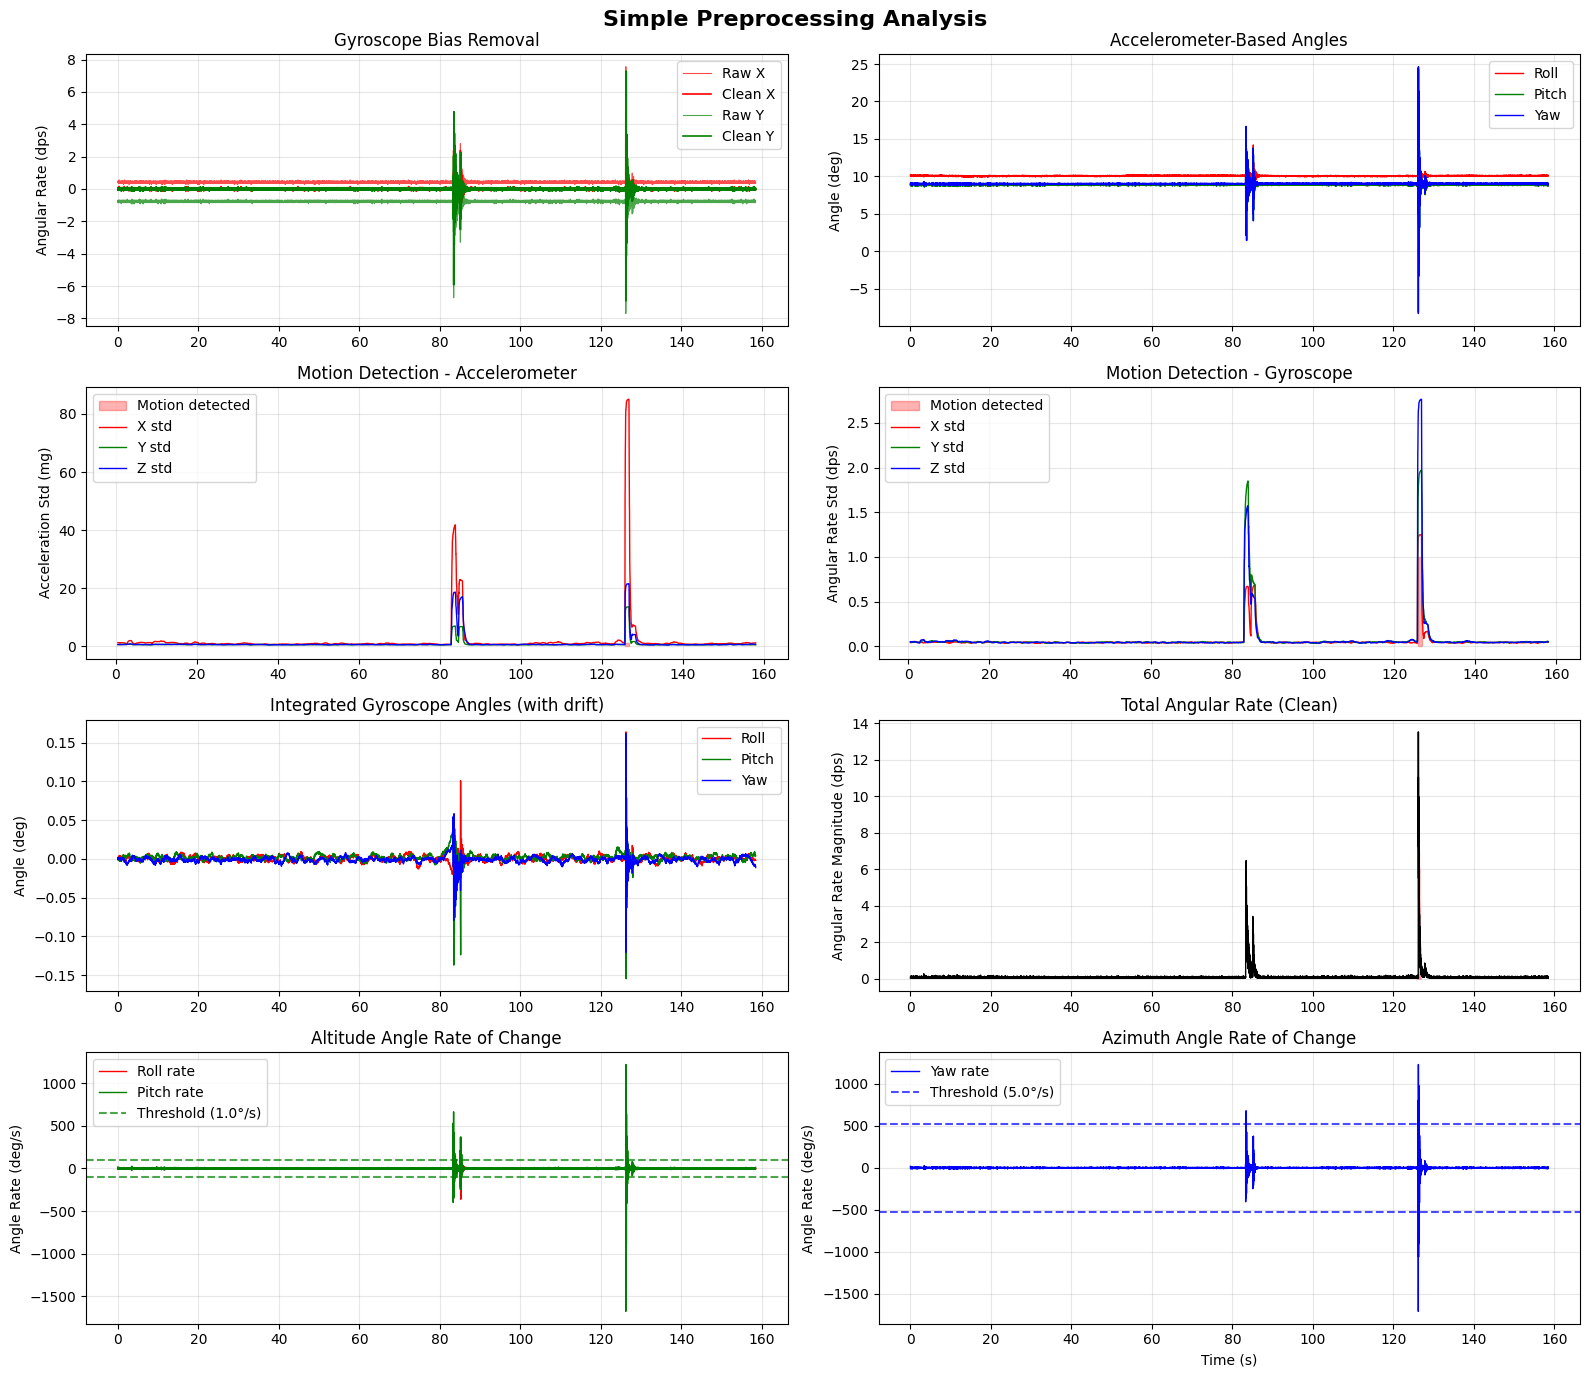

In [202]:
def plot_preprocessing_analysis(df, save_plots=False):
    time_s = (df['timestamp_us'] - df['timestamp_us'].iloc[0]) / 1e6
    
    # Calculate angles and clean gyro data
    accel_roll, accel_pitch, accel_yaw, rel_mask = calculate_accel_angles_wds(df)
    gyro_x_clean, gyro_y_clean, gyro_z_clean = remove_gyro_bias_using_sliding_window(df)
    
    # Motion detection
    motion_mask, (acc_x_std, acc_y_std, acc_z_std), (gyro_x_std, gyro_y_std, gyro_z_std) = detect_motion_periods(df)
    
    fig, axes = plt.subplots(4, 2, figsize=(16, 14))
    fig.suptitle('Simple Preprocessing Analysis', fontsize=16, fontweight='bold')
    
    # Raw vs clean gyro comparison
    axes[0, 0].plot(time_s, df['gyro_x_dps'], 'r-', alpha=0.7, linewidth=0.8, label='Raw X')
    axes[0, 0].plot(time_s, gyro_x_clean, 'r-', linewidth=1.2, label='Clean X')
    axes[0, 0].plot(time_s, df['gyro_y_dps'], 'g-', alpha=0.7, linewidth=0.8, label='Raw Y')
    axes[0, 0].plot(time_s, gyro_y_clean, 'g-', linewidth=1.2, label='Clean Y')
    axes[0, 0].set_ylabel('Angular Rate (dps)')
    axes[0, 0].set_title('Gyroscope Bias Removal')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Accelerometer angles
    axes[0, 1].plot(time_s, accel_roll, 'r-', linewidth=1, label='Roll')
    axes[0, 1].plot(time_s, accel_pitch, 'g-', linewidth=1, label='Pitch')
    axes[0, 1].plot(time_s, accel_yaw, 'b-', linewidth=1, label='Yaw')
    axes[0, 1].set_ylabel('Angle (deg)')
    axes[0, 1].set_title('Accelerometer-Based Angles')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # Motion detection - accelerometer
    axes[1, 0].fill_between(time_s, 0, 1, where=motion_mask, alpha=0.3, color='red', label='Motion detected')
    axes[1, 0].plot(time_s, acc_x_std, 'r-', linewidth=1, label='X std')
    axes[1, 0].plot(time_s, acc_y_std, 'g-', linewidth=1, label='Y std')
    axes[1, 0].plot(time_s, acc_z_std, 'b-', linewidth=1, label='Z std')
    axes[1, 0].set_ylabel('Acceleration Std (mg)')
    axes[1, 0].set_title('Motion Detection - Accelerometer')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # Motion detection - gyroscope
    axes[1, 1].fill_between(time_s, 0, 1, where=motion_mask, alpha=0.3, color='red', label='Motion detected')
    axes[1, 1].plot(time_s, gyro_x_std, 'r-', linewidth=1, label='X std')
    axes[1, 1].plot(time_s, gyro_y_std, 'g-', linewidth=1, label='Y std')
    axes[1, 1].plot(time_s, gyro_z_std, 'b-', linewidth=1, label='Z std')
    axes[1, 1].set_ylabel('Angular Rate Std (dps)')
    axes[1, 1].set_title('Motion Detection - Gyroscope')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    # Integrated gyro angles (with drift)
    gyro_roll_int = np.cumsum(gyro_x_clean) * DT
    gyro_pitch_int = np.cumsum(gyro_y_clean) * DT
    gyro_yaw_int = np.cumsum(gyro_z_clean) * DT
    
    axes[2, 0].plot(time_s, gyro_roll_int, 'r-', linewidth=1, label='Roll')
    axes[2, 0].plot(time_s, gyro_pitch_int, 'g-', linewidth=1, label='Pitch')
    axes[2, 0].plot(time_s, gyro_yaw_int, 'b-', linewidth=1, label='Yaw')
    axes[2, 0].set_ylabel('Angle (deg)')
    axes[2, 0].set_title('Integrated Gyroscope Angles (with drift)')
    axes[2, 0].legend()
    axes[2, 0].grid(True, alpha=0.3)
    
    # Angular velocity magnitude
    gyro_mag = np.sqrt(gyro_x_clean**2 + gyro_y_clean**2 + gyro_z_clean**2)
    axes[2, 1].plot(time_s, gyro_mag, 'k-', linewidth=1)
    axes[2, 1].fill_between(time_s, 0, gyro_mag, where=motion_mask, alpha=0.3, color='red')
    axes[2, 1].set_ylabel('Angular Rate Magnitude (dps)')
    axes[2, 1].set_title('Total Angular Rate (Clean)')
    axes[2, 1].grid(True, alpha=0.3)
    
    # Angle rate of change (for event detection)
    roll_rate = np.gradient(accel_roll) * FS
    pitch_rate = np.gradient(accel_pitch) * FS
    yaw_rate = np.gradient(accel_yaw) * FS
    
    axes[3, 0].plot(time_s, roll_rate, 'r-', linewidth=1, label='Roll rate')
    axes[3, 0].plot(time_s, pitch_rate, 'g-', linewidth=1, label='Pitch rate')
    axes[3, 0].axhline(y=ALTITUDE_THRESHOLD * FS, color='g', linestyle='--', alpha=0.7, label=f'Threshold ({ALTITUDE_THRESHOLD}°/s)')
    axes[3, 0].axhline(y=-ALTITUDE_THRESHOLD * FS, color='g', linestyle='--', alpha=0.7)
    axes[3, 0].set_ylabel('Angle Rate (deg/s)')
    axes[3, 0].set_title('Altitude Angle Rate of Change')
    axes[3, 0].legend()
    axes[3, 0].grid(True, alpha=0.3)
    
    axes[3, 1].plot(time_s, yaw_rate, 'b-', linewidth=1, label='Yaw rate')
    axes[3, 1].axhline(y=AZIMUTH_THRESHOLD * FS, color='b', linestyle='--', alpha=0.7, label=f'Threshold ({AZIMUTH_THRESHOLD}°/s)')
    axes[3, 1].axhline(y=-AZIMUTH_THRESHOLD * FS, color='b', linestyle='--', alpha=0.7)
    axes[3, 1].set_ylabel('Angle Rate (deg/s)')
    axes[3, 1].set_xlabel('Time (s)')
    axes[3, 1].set_title('Azimuth Angle Rate of Change')
    axes[3, 1].legend()
    axes[3, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    if save_plots:
        plt.savefig('preprocessing_analysis.png', dpi=300, bbox_inches='tight')
        print("Preprocessing analysis saved as 'preprocessing_analysis.png'")
    
    return fig, (accel_roll, accel_pitch, accel_yaw), (gyro_x_clean, gyro_y_clean, gyro_z_clean), motion_mask

fig_pre, accel_euler, gyro_euler, mask = plot_preprocessing_analysis(df)

## Simple filtering

### Complementary filter

In [203]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


def complementary_filter_simple(accel_angles, gyro_rates, alpha=0.98, sample_rate_hz=104):
    """
    Simple complementary filter: alpha*gyro + (1-alpha)*accel
    """
    accel_roll, accel_pitch, accel_yaw = accel_angles
    gyro_x_clean, gyro_y_clean, gyro_z_clean = gyro_rates
    
    dt = 1.0 / sample_rate_hz
    
    # Initialize with accelerometer
    filt_roll = np.zeros(len(accel_roll))
    filt_pitch = np.zeros(len(accel_pitch))
    filt_yaw = np.zeros(len(accel_yaw))
    
    filt_roll[0] = accel_roll.iloc[0]
    filt_pitch[0] = accel_pitch.iloc[0] 
    filt_yaw[0] = accel_yaw.iloc[0]
    
    # Apply filter
    for i in range(1, len(filt_roll)):
        filt_roll[i] = alpha * (filt_roll[i-1] + gyro_x_clean.iloc[i] * dt) + (1-alpha) * accel_roll.iloc[i]
        filt_pitch[i] = alpha * (filt_pitch[i-1] + gyro_y_clean.iloc[i] * dt) + (1-alpha) * accel_pitch.iloc[i]
        filt_yaw[i] = alpha * (filt_yaw[i-1] + gyro_z_clean.iloc[i] * dt) + (1-alpha) * accel_yaw.iloc[i]
    
    return filt_roll, filt_pitch, filt_yaw

def complementary_filter_adaptive(accel_angles, gyro_rates, motion_mask, 
                                alpha_static=0.95, alpha_dynamic=0.85, sample_rate_hz=104):
    accel_roll, accel_pitch, accel_yaw = accel_angles
    gyro_x_clean, gyro_y_clean, gyro_z_clean = gyro_rates
    
    dt = 1.0 / sample_rate_hz
    n_samples = len(accel_roll)
    
    # Initialize with accelerometer
    filt_roll = np.zeros(n_samples)
    filt_pitch = np.zeros(n_samples)
    filt_yaw = np.zeros(n_samples)
    
    filt_roll[0] = accel_roll[0]
    filt_pitch[0] = accel_pitch[0]
    filt_yaw[0] = accel_yaw[0]
    
    # Apply adaptive filter
    for i in range(1, n_samples):
        # Choose alpha based on motion detection
        alpha = alpha_dynamic if motion_mask.iloc[i] else alpha_static
        
        # Complementary filter
        filt_roll[i] = alpha * (filt_roll[i-1] + gyro_x_clean.iloc[i] * dt) + (1-alpha) * accel_roll[i]
        filt_pitch[i] = alpha * (filt_pitch[i-1] + gyro_y_clean.iloc[i] * dt) + (1-alpha) * accel_pitch[i]
        filt_yaw[i] = alpha * (filt_yaw[i-1] + gyro_z_clean.iloc[i] * dt) + (1-alpha) * accel_yaw[i]
    
    return filt_roll, filt_pitch, filt_yaw

def reset_based_filter(accel_angles, gyro_rates, reset_threshold_deg=10, reset_window_s=2.0):
    """
    Simple filter with periodic resets to prevent drift accumulation
    """
    accel_roll, accel_pitch, accel_yaw = accel_angles
    gyro_x_clean, gyro_y_clean, gyro_z_clean = gyro_rates
    
    dt = DT
    n_samples = len(accel_roll)
    reset_window_samples = int(reset_window_s * FS)
    
    # Initialize
    filt_roll = np.zeros(n_samples)
    filt_pitch = np.zeros(n_samples)
    filt_yaw = np.zeros(n_samples)
    
    filt_roll[0] = accel_roll[0]
    filt_pitch[0] = accel_pitch[0]
    filt_yaw[0] = accel_yaw[0]
    
    last_reset = 0
    
    for i in range(1, n_samples):
        # Integrate gyroscope
        filt_roll[i] = filt_roll[i-1] + gyro_x_clean.iloc[i] * dt
        filt_pitch[i] = filt_pitch[i-1] + gyro_y_clean.iloc[i] * dt
        filt_yaw[i] = filt_yaw[i-1] + gyro_z_clean.iloc[i] * dt
        
        # Check for reset conditions
        should_reset = False
        
        # Time-based reset
        if (i - last_reset) > reset_window_samples:
            should_reset = True
            
        # Drift-based reset
        drift_roll = abs(filt_roll[i] - accel_roll[i])
        drift_pitch = abs(filt_pitch[i] - accel_pitch[i])
        
        if drift_roll > reset_threshold_deg or drift_pitch > reset_threshold_deg:
            should_reset = True
            
        if should_reset:
            # Reset to accelerometer values
            filt_roll[i] = accel_roll[i]
            filt_pitch[i] = accel_pitch[i]
            filt_yaw[i] = accel_yaw[i]  # Keep yaw from gyro integration
            last_reset = i
    
    return filt_roll, filt_pitch, filt_yaw

def detect_angle_events(angles, timestamps, altitude_threshold=1.0, azimuth_threshold=5.0, 
                                min_event_separation=0.5, actual_fs=52):
    roll, pitch, yaw = angles
    time_s = (timestamps - timestamps[0]) / 1e6
    
    # Calculate rates using smooth differentiation
    dt = np.median(np.diff(time_s))
    roll_rate = np.gradient(roll, dt)
    pitch_rate = np.gradient(pitch, dt)  
    yaw_rate = np.gradient(yaw, dt)
    
    # Apply light smoothing to rates to reduce noise
    roll_rate_smooth = signal.savgol_filter(roll_rate, window_length=max(3, int(actual_fs*0.1)), polyorder=2)
    pitch_rate_smooth = signal.savgol_filter(pitch_rate, window_length=max(3, int(actual_fs*0.1)), polyorder=2)
    yaw_rate_smooth = signal.savgol_filter(yaw_rate, window_length=max(3, int(actual_fs*0.1)), polyorder=2)
    
    # Detect events with smoothed rates
    altitude_events = (np.abs(roll_rate_smooth) > altitude_threshold) | (np.abs(pitch_rate_smooth) > altitude_threshold)
    azimuth_events = np.abs(yaw_rate_smooth) > azimuth_threshold
    
    # Find event indices and filter for minimum separation
    def filter_events(event_mask, min_separation_samples):
        event_indices = np.where(event_mask)[0]
        if len(event_indices) == 0:
            return event_indices
            
        filtered_indices = [event_indices[0]]
        for idx in event_indices[1:]:
            if idx - filtered_indices[-1] > min_separation_samples:
                filtered_indices.append(idx)
        return np.array(filtered_indices)
    
    min_separation_samples = int(min_event_separation * actual_fs)
    altitude_indices = filter_events(altitude_events, min_separation_samples)
    azimuth_indices = filter_events(azimuth_events, min_separation_samples)
    
    # Calculate event magnitudes
    altitude_magnitudes = []
    azimuth_magnitudes = []
    
    for idx in altitude_indices:
        mag = max(abs(roll_rate_smooth[idx]), abs(pitch_rate_smooth[idx]))
        altitude_magnitudes.append(mag)
        
    for idx in azimuth_indices:
        azimuth_magnitudes.append(abs(yaw_rate_smooth[idx]))
    
    print(f"EVENT DETECTION RESULTS:")
    print(f"   - Altitude events: {len(altitude_indices)} (threshold: {altitude_threshold}deg/s)")
    if len(altitude_magnitudes) > 0:
        print(f"     - Max magnitude: {np.max(altitude_magnitudes):.1f}deg/s")
        print(f"     - Mean magnitude: {np.mean(altitude_magnitudes):.1f}deg/s")
        
    print(f"   - Azimuth events: {len(azimuth_indices)} (threshold: {azimuth_threshold}deg/s)")
    if len(azimuth_magnitudes) > 0:
        print(f"     - Max magnitude: {np.max(azimuth_magnitudes):.1f}deg/s")
        print(f"     - Mean magnitude: {np.mean(azimuth_magnitudes):.1f}deg/s")
    
    return {
        'altitude_events': altitude_events,
        'azimuth_events': azimuth_events,
        'altitude_indices': altitude_indices,
        'azimuth_indices': azimuth_indices,
        'rates': (roll_rate_smooth, pitch_rate_smooth, yaw_rate_smooth),
        'magnitudes': {
            'altitude': altitude_magnitudes,
            'azimuth': azimuth_magnitudes
        },
        'time_s': time_s
    }

def analyze_gyro_drift_effects(df_raw_, title="Gyroscope Drift Analysis", gyro_is_mdps=False):
    """
    Clear comparison of accelerometer vs gyro vs combined angle estimation.
    Includes yaw analysis for tilted sensor mount.
    """
    print("=== GYROSCOPE DRIFT ANALYSIS ===")

    if gyro_is_mdps:
        df_raw = df_raw_.copy()
        df_raw[['gyro_x_dps', 'gyro_y_dps', 'gyro_z_dps']] /= 1000
    
    # Calculate all angle estimates
    accel_roll, accel_pitch, accel_yaw = calculate_accel_angles_wds(df_raw)
    gyro_roll_int, gyro_pitch_int, gyro_yaw_int = integrate_gyro_to_angles(df_raw)
    gyro_rates = remove_gyro_bias_using_mean(df_raw)
    filt_roll, filt_pitch, filt_yaw = complementary_filter_simple(
        (accel_roll, accel_pitch, accel_yaw), gyro_rates, alpha=0.98
    )
    

EVENT DETECTION RESULTS:
   - Altitude events: 611 (threshold: 1.0deg/s)
     - Max magnitude: 76719847.0deg/s
     - Mean magnitude: 353674.3deg/s
   - Azimuth events: 611 (threshold: 5.0deg/s)
     - Max magnitude: 80976004.0deg/s
     - Mean magnitude: 341406.4deg/s
EVENT DETECTION RESULTS:
   - Altitude events: 611 (threshold: 1.0deg/s)
     - Max magnitude: 472254970.0deg/s
     - Mean magnitude: 1266380.4deg/s
   - Azimuth events: 611 (threshold: 5.0deg/s)
     - Max magnitude: 482354690.9deg/s
     - Mean magnitude: 1276593.6deg/s


TypeError: Axes.pie() got an unexpected keyword argument 'alpha'

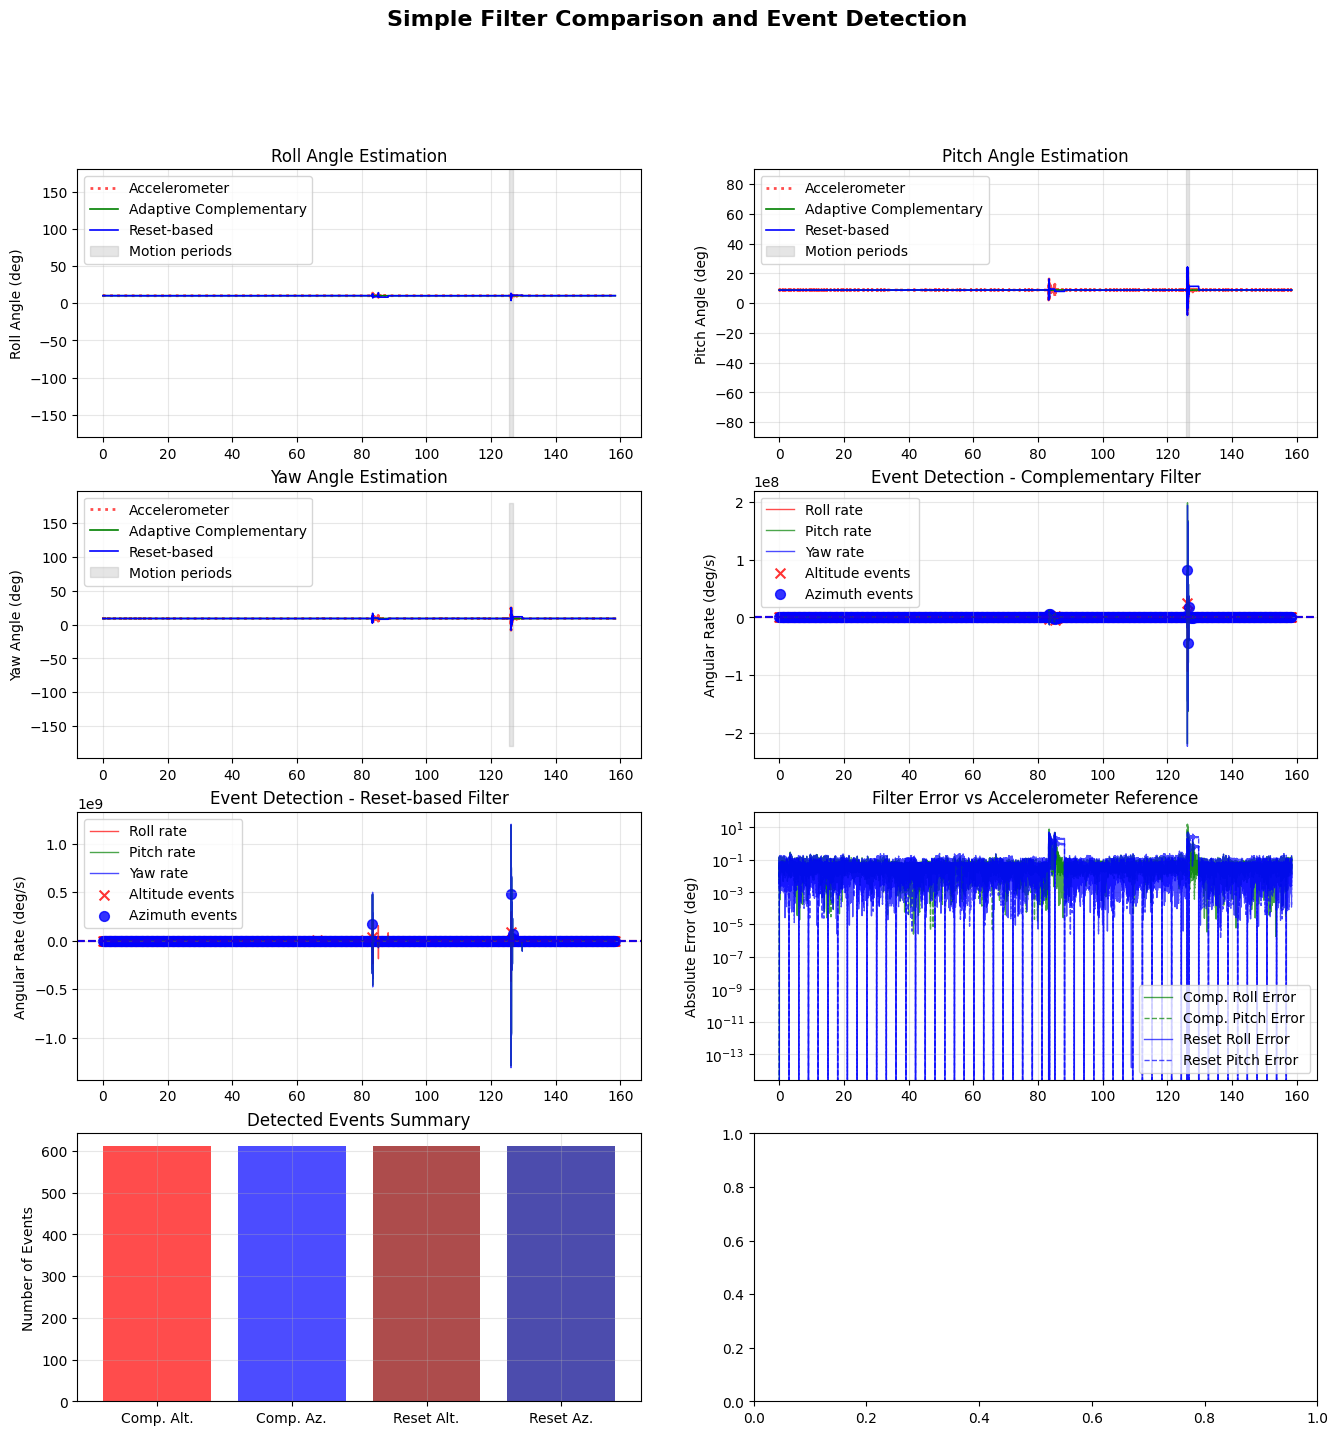

In [204]:
def plot_filter_comparison(df, accel_angles, gyro_rates, motion_mask, save_plots=False):
    """
    Compare different filtering approaches
    """
    time_s = (df['timestamp_us'] - df['timestamp_us'].iloc[0]) / 1e6
    accel_roll, accel_pitch, accel_yaw = accel_angles
    
    # Apply different filters
    comp_roll, comp_pitch, comp_yaw = complementary_filter_adaptive(
        accel_angles, gyro_rates, motion_mask, alpha_static=0.98, alpha_dynamic=0.85)
    
    reset_roll, reset_pitch, reset_yaw = reset_based_filter(
        accel_angles, gyro_rates, reset_threshold_deg=5, reset_window_s=3.0)
    
    # Detect events
    comp_events = detect_angle_events((comp_roll, comp_pitch, comp_yaw), time_s)
    reset_events = detect_angle_events((reset_roll, reset_pitch, reset_yaw), time_s)
    
    fig, axes = plt.subplots(4, 2, figsize=(16, 16))
    fig.suptitle('Simple Filter Comparison and Event Detection', fontsize=16, fontweight='bold')
    
    # Roll comparison
    axes[0, 0].plot(time_s, accel_roll, 'r:', linewidth=2, alpha=0.7, label='Accelerometer')
    axes[0, 0].plot(time_s, comp_roll, 'g-', linewidth=1.2, label='Adaptive Complementary')
    axes[0, 0].plot(time_s, reset_roll, 'b-', linewidth=1.2, label='Reset-based')
    axes[0, 0].fill_between(time_s, -180, 180, where=motion_mask, alpha=0.2, color='gray', label='Motion periods')
    axes[0, 0].set_ylabel('Roll Angle (deg)')
    axes[0, 0].set_title('Roll Angle Estimation')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    axes[0, 0].set_ylim([-180, 180])
    
    # Pitch comparison
    axes[0, 1].plot(time_s, accel_pitch, 'r:', linewidth=2, alpha=0.7, label='Accelerometer')
    axes[0, 1].plot(time_s, comp_pitch, 'g-', linewidth=1.2, label='Adaptive Complementary')
    axes[0, 1].plot(time_s, reset_pitch, 'b-', linewidth=1.2, label='Reset-based')
    axes[0, 1].fill_between(time_s, -90, 90, where=motion_mask, alpha=0.2, color='gray', label='Motion periods')
    axes[0, 1].set_ylabel('Pitch Angle (deg)')
    axes[0, 1].set_title('Pitch Angle Estimation')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    axes[0, 1].set_ylim([-90, 90])
    
    # Yaw comparison
    axes[1, 0].plot(time_s, accel_yaw, 'r:', linewidth=2, alpha=0.7, label='Accelerometer')
    axes[1, 0].plot(time_s, comp_yaw, 'g-', linewidth=1.2, label='Adaptive Complementary')
    axes[1, 0].plot(time_s, reset_yaw, 'b-', linewidth=1.2, label='Reset-based')
    axes[1, 0].fill_between(time_s, -180, 180, where=motion_mask, alpha=0.2, color='gray', label='Motion periods')
    axes[1, 0].set_ylabel('Yaw Angle (deg)')
    axes[1, 0].set_title('Yaw Angle Estimation')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # Event detection - Complementary filter
    comp_roll_rate, comp_pitch_rate, comp_yaw_rate = comp_events['rates']
    axes[1, 1].plot(time_s, comp_roll_rate, 'r-', linewidth=1, alpha=0.7, label='Roll rate')
    axes[1, 1].plot(time_s, comp_pitch_rate, 'g-', linewidth=1, alpha=0.7, label='Pitch rate')
    axes[1, 1].plot(time_s, comp_yaw_rate, 'b-', linewidth=1, alpha=0.7, label='Yaw rate')
    
    # Event markers
    if len(comp_events['altitude_indices']) > 0:
        axes[1, 1].scatter(time_s[comp_events['altitude_indices']], 
                          comp_roll_rate[comp_events['altitude_indices']], 
                          c='red', s=50, marker='x', alpha=0.8, label='Altitude events')
    if len(comp_events['azimuth_indices']) > 0:
        axes[1, 1].scatter(time_s[comp_events['azimuth_indices']], 
                          comp_yaw_rate[comp_events['azimuth_indices']], 
                          c='blue', s=50, marker='o', alpha=0.8, label='Azimuth events')
    
    axes[1, 1].axhline(y=ALTITUDE_THRESHOLD, color='red', linestyle='--', alpha=0.7)
    axes[1, 1].axhline(y=-ALTITUDE_THRESHOLD, color='red', linestyle='--', alpha=0.7)
    axes[1, 1].axhline(y=AZIMUTH_THRESHOLD, color='blue', linestyle='--', alpha=0.7)
    axes[1, 1].axhline(y=-AZIMUTH_THRESHOLD, color='blue', linestyle='--', alpha=0.7)
    axes[1, 1].set_ylabel('Angular Rate (deg/s)')
    axes[1, 1].set_title('Event Detection - Complementary Filter')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    # Event detection - Reset-based filter
    reset_roll_rate, reset_pitch_rate, reset_yaw_rate = reset_events['rates']
    axes[2, 0].plot(time_s, reset_roll_rate, 'r-', linewidth=1, alpha=0.7, label='Roll rate')
    axes[2, 0].plot(time_s, reset_pitch_rate, 'g-', linewidth=1, alpha=0.7, label='Pitch rate')
    axes[2, 0].plot(time_s, reset_yaw_rate, 'b-', linewidth=1, alpha=0.7, label='Yaw rate')
    
    # Event markers
    if len(reset_events['altitude_indices']) > 0:
        axes[2, 0].scatter(time_s[reset_events['altitude_indices']], 
                          reset_roll_rate[reset_events['altitude_indices']], 
                          c='red', s=50, marker='x', alpha=0.8, label='Altitude events')
    if len(reset_events['azimuth_indices']) > 0:
        axes[2, 0].scatter(time_s[reset_events['azimuth_indices']], 
                          reset_yaw_rate[reset_events['azimuth_indices']], 
                          c='blue', s=50, marker='o', alpha=0.8, label='Azimuth events')
    
    axes[2, 0].axhline(y=ALTITUDE_THRESHOLD, color='red', linestyle='--', alpha=0.7)
    axes[2, 0].axhline(y=-ALTITUDE_THRESHOLD, color='red', linestyle='--', alpha=0.7)
    axes[2, 0].axhline(y=AZIMUTH_THRESHOLD, color='blue', linestyle='--', alpha=0.7)
    axes[2, 0].axhline(y=-AZIMUTH_THRESHOLD, color='blue', linestyle='--', alpha=0.7)
    axes[2, 0].set_ylabel('Angular Rate (deg/s)')
    axes[2, 0].set_title('Event Detection - Reset-based Filter')
    axes[2, 0].legend()
    axes[2, 0].grid(True, alpha=0.3)
    
    # Filter error comparison
    comp_roll_error = np.abs(comp_roll - accel_roll)
    comp_pitch_error = np.abs(comp_pitch - accel_pitch)
    reset_roll_error = np.abs(reset_roll - accel_roll)
    reset_pitch_error = np.abs(reset_pitch - accel_pitch)
    
    axes[2, 1].plot(time_s, comp_roll_error, 'g-', linewidth=1, alpha=0.7, label='Comp. Roll Error')
    axes[2, 1].plot(time_s, comp_pitch_error, 'g--', linewidth=1, alpha=0.7, label='Comp. Pitch Error')
    axes[2, 1].plot(time_s, reset_roll_error, 'b-', linewidth=1, alpha=0.7, label='Reset Roll Error')
    axes[2, 1].plot(time_s, reset_pitch_error, 'b--', linewidth=1, alpha=0.7, label='Reset Pitch Error')
    axes[2, 1].set_ylabel('Absolute Error (deg)')
    axes[2, 1].set_title('Filter Error vs Accelerometer Reference')
    axes[2, 1].legend()
    axes[2, 1].grid(True, alpha=0.3)
    axes[2, 1].set_yscale('log')
    
    # Event statistics
    axes[3, 0].bar(['Comp. Alt.', 'Comp. Az.', 'Reset Alt.', 'Reset Az.'], 
                  [len(comp_events['altitude_indices']), len(comp_events['azimuth_indices']),
                   len(reset_events['altitude_indices']), len(reset_events['azimuth_indices'])],
                  color=['red', 'blue', 'darkred', 'darkblue'], alpha=0.7)
    axes[3, 0].set_ylabel('Number of Events')
    axes[3, 0].set_title('Detected Events Summary')
    axes[3, 0].grid(True, alpha=0.3)
    
    # Motion periods analysis
    motion_duration = np.sum(motion_mask) * DT
    total_duration = len(motion_mask) * DT
    motion_percentage = 100 * motion_duration / total_duration
    
    axes[3, 1].pie([motion_duration, total_duration - motion_duration], 
                  labels=[f'Motion\n({motion_percentage:.1f}%)', 
                          f'Static\n({100-motion_percentage:.1f}%)'],
                  colors=['red', 'lightblue'], autopct='%1.1f%%', alpha=0.7)
    axes[3, 1].set_title('Motion vs Static Time Distribution')
    
    plt.tight_layout()
    
    if save_plots:
        plt.savefig('filter_comparison.png', dpi=300, bbox_inches='tight')
        print("Filter comparison saved as 'filter_comparison.png'")
    
    # Print event summary
    print("\n" + "="*60)
    print("EVENT DETECTION SUMMARY")
    print("="*60)
    print(f"Complementary Filter:")
    print(f"  - Altitude events: {len(comp_events['altitude_indices'])}")
    print(f"  - Azimuth events:  {len(comp_events['azimuth_indices'])}")
    print(f"Reset-based Filter:")
    print(f"  - Altitude events: {len(reset_events['altitude_indices'])}")
    print(f"  - Azimuth events:  {len(reset_events['azimuth_indices'])}")
    print(f"\nMotion Analysis:")
    print(f"  - Total duration: {total_duration:.1f} seconds")
    print(f"  - Motion time: {motion_duration:.1f} seconds ({motion_percentage:.1f}%)")
    print(f"  - Static time: {total_duration - motion_duration:.1f} seconds ({100-motion_percentage:.1f}%)")
    
    return fig, {
        'complementary': {'angles': (comp_roll, comp_pitch, comp_yaw), 'events': comp_events},
        'reset_based': {'angles': (reset_roll, reset_pitch, reset_yaw), 'events': reset_events}
    }

plot_filter_comparison(df, accel_angles=accel_euler, gyro_rates=gyro_euler, motion_mask=mask)

# Advanced Methods

## Advanced Preprocessing

In [ ]:
def preprocess_imu_data(acc_data, gyro_data, cutoff_freq=20.0, fs=104.0):
    nyquist = fs / 2.0
    normal_cutoff = cutoff_freq / nyquist
    b, a = signal.butter(4, normal_cutoff, btype='low', analog=False)
    
    acc_filtered = np.zeros_like(acc_data)
    gyro_filtered = np.zeros_like(gyro_data)
    
    for i in range(3):
        acc_filtered[:, i] = signal.filtfilt(b, a, acc_data[:, i])
        gyro_filtered[:, i] = signal.filtfilt(b, a, gyro_data[:, i])
    
    # Remove gyroscope bias (estimate from first 100 samples when static)
    gyro_bias = np.mean(gyro_filtered[:100], axis=0)
    gyro_filtered -= gyro_bias
    
    print(f"Removed gyroscope bias: [{gyro_bias[0]:.4f}, {gyro_bias[1]:.4f}, {gyro_bias[2]:.4f}] rad/s")
    
    return acc_filtered, gyro_filtered


## Advanced Filtering

In [ ]:
def madgwick_filter(acc_data_mg, gyro_data_mdps):
    # Convert units
    acc_data  = acc_data_mg * 9.80665 / 1000.0  # mg to m/s*s
    gyro_data = gyro_data_mdps * np.pi / (180.0 * 1000)  # mdps to rad/s
    print(f"After unit conversion:")
    print(f"Accelerometer: X[{acc_data[:,0].min():.3f}, {acc_data[:,0].max():.3f}] m/s*s")
    print(f"Gyroscope: X[{gyro_data[:,0].min():.4f}, {gyro_data[:,0].max():.4f}] rad/s*s")


    # Prepare arrays
    acc,gyr = wds_to_enu(acc_data,gyro_data)
    # Initialize madwick
    madg = madgwick.Madgwick(frequency=104.0,q0=[1, 0.0, 0.0, 0.0])
    quaternions = np.tile([1., 0., 0., 0.], (len(df), 1))

    euler_angles = np.zeros((len(df),3))

    # Apply filter
    for t in range(len(df)):
        quaternions[t] = madg.updateIMU(quaternions[t-1], gyr=gyr[t], acc=acc[t])
        euler_angles[t] = np.rad2deg(q2euler(quaternions[t]))

    # Save output
    output_df = pd.DataFrame({
        'timestamp_us': df['timestamp_us'],
        'roll_deg': euler_angles[:, 0],
        'pitch_deg': euler_angles[:, 1],
        'yaw_deg': euler_angles[:, 2]
    })
    output_df.to_csv("madgwick_orientation_output.csv", index=False)
    return euler_angles, acc,gyr, output_df

In [ ]:
euler_angles, acc, gyr, output_df = madgwick_filter(acc_data_mg, gyro_data_mdps)

In [ ]:
acc_filtered, gyro_filtered = preprocess_imu_data(acc_data_mg, gyro_data_mdps)
prefilter_euler_angles, filtered_acc, filtered_gyr, filtered_output_df = madgwick_filter(acc_filtered, gyro_filtered)

In [ ]:
def plot_accelerometer_data(df, acc_data, title_suffix=""):
    fig, axes = plt.subplots(3, 1, figsize=(12, 8))
    fig.suptitle(f'Accelerometer Data{title_suffix}', fontsize=14, fontweight='bold')
    
    time_s = (df['timestamp_us'] - df['timestamp_us'].iloc[0]) / 1e6
    
    axes[0].plot(time_s, acc_data_mg[:, 0], 'r-', linewidth=1)
    axes[0].set_ylabel('Acc X (m/s*s)')
    axes[0].grid(True, alpha=0.3)
    axes[0].set_title('X-axis Acceleration')
    
    axes[1].plot(time_s, acc_data_mg[:, 1], 'g-', linewidth=1)
    axes[1].set_ylabel('Acc Y (m/s*s)')
    axes[1].grid(True, alpha=0.3)
    axes[1].set_title('Y-axis Acceleration')
    
    axes[2].plot(time_s, acc_data_mg[:, 2], 'b-', linewidth=1)
    axes[2].set_ylabel('Acc Z (m/s*s)')
    axes[2].set_xlabel('Time (s)')
    axes[2].grid(True, alpha=0.3)
    axes[2].set_title('Z-axis Acceleration')
    
    plt.tight_layout()
    return fig

def plot_gyroscope_data(df, gyro_data, title_suffix=""):
    fig, axes = plt.subplots(3, 1, figsize=(12, 8))
    fig.suptitle(f'Gyroscope Data{title_suffix}', fontsize=14, fontweight='bold')
    
    time_s = (df['timestamp_us'] - df['timestamp_us'].iloc[0]) / 1e6
    
    axes[0].plot(time_s, gyro_data_mdps[:, 0], 'r-', linewidth=1)
    axes[0].set_ylabel('Gyro X (dps)')
    axes[0].grid(True, alpha=0.3)
    axes[0].set_title('X-axis Angular Rate')
    
    axes[1].plot(time_s, gyro_data_mdps[:, 1], 'g-', linewidth=1)
    axes[1].set_ylabel('Gyro Y (dps)')
    axes[1].grid(True, alpha=0.3)
    axes[1].set_title('Y-axis Angular Rate')
    
    axes[2].plot(time_s, gyro_data_mdps[:, 2], 'b-', linewidth=1)
    axes[2].set_ylabel('Gyro Z (dps)')
    axes[2].set_xlabel('Time (s)')
    axes[2].grid(True, alpha=0.3)
    axes[2].set_title('Z-axis Angular Rate')
    
    plt.tight_layout()
    return fig

def plot_euler_angles(output_df, title_suffix=""):
    fig, axes = plt.subplots(3, 1, figsize=(12, 8))
    fig.suptitle(f'Euler Angles{title_suffix}', fontsize=14, fontweight='bold')
    
    time_s = (output_df['timestamp_us'] - output_df['timestamp_us'].iloc[0]) / 1e6
    
    axes[0].plot(time_s, output_df['roll_deg'], 'r-', linewidth=1)
    axes[0].set_ylabel('Roll (deg)')
    axes[0].grid(True, alpha=0.3)
    axes[0].set_title('Roll Angle')
    
    axes[1].plot(time_s, output_df['pitch_deg'], 'g-', linewidth=1)
    axes[1].set_ylabel('Pitch (deg)')
    axes[1].grid(True, alpha=0.3)
    axes[1].set_title('Pitch Angle')
    
    axes[2].plot(time_s, output_df['yaw_deg'], 'b-', linewidth=1)
    axes[2].set_ylabel('Yaw (deg)')
    axes[2].set_xlabel('Time (s)')
    axes[2].grid(True, alpha=0.3)
    axes[2].set_title('Yaw Angle')
    
    plt.tight_layout()
    return fig

def plot_all_imu_data(df, acc_data, gyro_data, output_df, save_plots=False):
    # Create all plots
    fig1 = plot_accelerometer_data(df, acc_data)
    fig2 = plot_gyroscope_data(df, gyro_data)
    fig3 = plot_euler_angles(output_df)
    
    if save_plots:
        fig1.savefig('accelerometer_data.png', dpi=300, bbox_inches='tight')
        fig2.savefig('gyroscope_data.png', dpi=300, bbox_inches='tight')
        fig3.savefig('euler_angles.png', dpi=300, bbox_inches='tight')
        print("Plots saved as PNG files")
    
    plt.show()
    return fig1, fig2, fig3


In [ ]:
fig1a = plot_accelerometer_data(df, acc, " - WDS Coordinate System")
fig1b = plot_accelerometer_data(df, acc_filtered, " - FILTERED WDS Coordinate System")
fig2a = plot_gyroscope_data(df, gyr, " - WDS Coordinate System") 
fig2b = plot_gyroscope_data(df, gyro_filtered, " - FILTERED WDS Coordinate System") 
fig3a = plot_euler_angles(output_df, " - Madgwick Filter Output")
fig3b = plot_euler_angles(filtered_output_df, " - FILTERED Madgwick Filter Output")